# TP 2 - Procesamiento del Lenguaje Natural

## Librerias y Funciones


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score,  recall_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import confusion_matrix
from mlxtend.preprocessing import DenseTransformer
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from langdetect import detect
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.layers import Dense, Activation
# from tensorflow.keras.optimizers import SGD
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.layers import LSTM, Embedding, GRU
# from tensorflow.keras.layers import Input
from nltk.tokenize.toktok import ToktokTokenizer
from emoji import emoji_count, demojize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
import os
# import pickle
# import spacy
from sklearn.tree import DecisionTreeClassifier
# from keras.optimizers.legacy import Adam
# from keras.layers import Input, Dense, Embedding, Concatenate, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D, Bidirectional, GRU, Flatten, Conv1D, MaxPooling1D, LSTM
# from tensorflow.keras.models import Model

In [72]:
def mostrar_scores(y_test: np.ndarray, y_prediccion: np.ndarray):
    accuracy = accuracy_score(y_test,y_prediccion)
    recall = recall_score(y_test,y_prediccion)
    f1 = f1_score(y_test,y_prediccion,)
    precision = precision_score(y_test,y_prediccion)

    print("Accuracy: "+str(accuracy))
    print("Recall: "+str(recall))
    print("Precision: "+str(precision))
    print("f1 score: "+str(f1))

def cantidad_de_palabras(review):
    return len(review.split())

## Analisis Exploratorio

Comenzamos con el analisis exploratorio de los datos, para ello vamos a cargar los datos y a ver como estan distribuidos.

In [4]:
df = pd.read_csv('datasets/train.csv', sep=',')
df.head(10)

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo
5,5,Probablemente mi película favorita de todos lo...,positivo
6,6,Seguro que me gustaría ver una resurrección de...,positivo
7,7,"Este espectáculo fue una idea increíble, fresc...",negativo
8,8,Alentados por los comentarios positivos sobre ...,negativo
9,9,"Si te gusta la risa original desgarradora, te ...",positivo


Podemos observar que contamos con un total de 50000 reviews

In [74]:
df.shape

(50000, 3)

Como se puede observar en la siguiente celda, veremos la distribucion del sentimiento de las reviews, con mitad de las mismas positivas y mitad de reviews negativas.

In [75]:
df.value_counts('sentimiento')

sentimiento
negativo    25000
positivo    25000
Name: count, dtype: int64

A continuacion vamos a adentrarnos a analizar las caracteristicas de las reviews en general.

En primer lugar vamos a analizar el dataset para ver si contiene emojis

In [76]:
df['tiene_emoji'] = df['review_es'].apply(emoji_count)
cantidad_emojis = df['tiene_emoji'].value_counts().reset_index()
cantidad_emojis.columns = ['cantidad_emojis', 'cantidad_filas']
cantidad_emojis

,cantidad_emojis,cantidad_filas
0,0,49995
1,1,5


Por otro lado, buscaremos saber como se distribuye la longitud de las reviews. Para ello, vamos a calcular la cantidad de palabras de cada review.

In [77]:
df['cantidad_de_palabras'] = df['review_es'].apply(cantidad_de_palabras)

In [78]:
df['cantidad_de_palabras'].describe()

count    50000.000000
mean       237.233680
std        179.529306
min          6.000000
25%        123.000000
50%        172.000000
75%        293.000000
max       2450.000000
Name: cantidad_de_palabras, dtype: float64

Ahora realizaremos un analisis grafico de la cantidad de palabras para ver si encontramos ciertas tendencias.

/Users/juampi/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/juampi/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/juampi/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/juampi/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

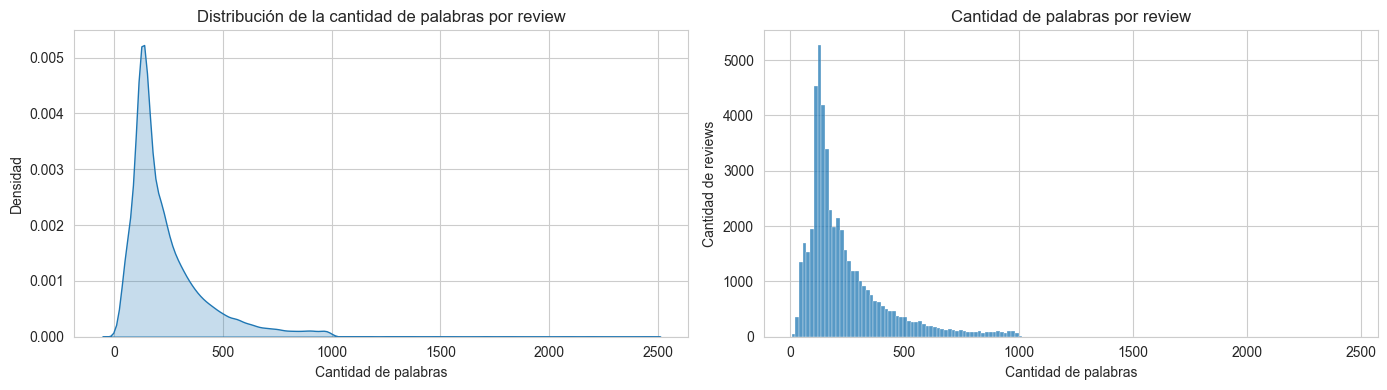

In [79]:
sns.set_style('whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

sns.kdeplot(df['cantidad_de_palabras'], fill=True, ax=ax1).set_title('Distribución de la cantidad de palabras por review')
ax1.set_ylabel('Densidad')
ax1.set_xlabel('Cantidad de palabras')

sns.histplot(df['cantidad_de_palabras'],  ax=ax2, bins=150, kde=False).set_title('Distribución de la cantidad de palabras por review')
ax2.set_xlabel('Cantidad de palabras')
ax2.set_ylabel('Cantidad de reviews')

plt.title('Cantidad de palabras por review')
plt.tight_layout()
plt.show()

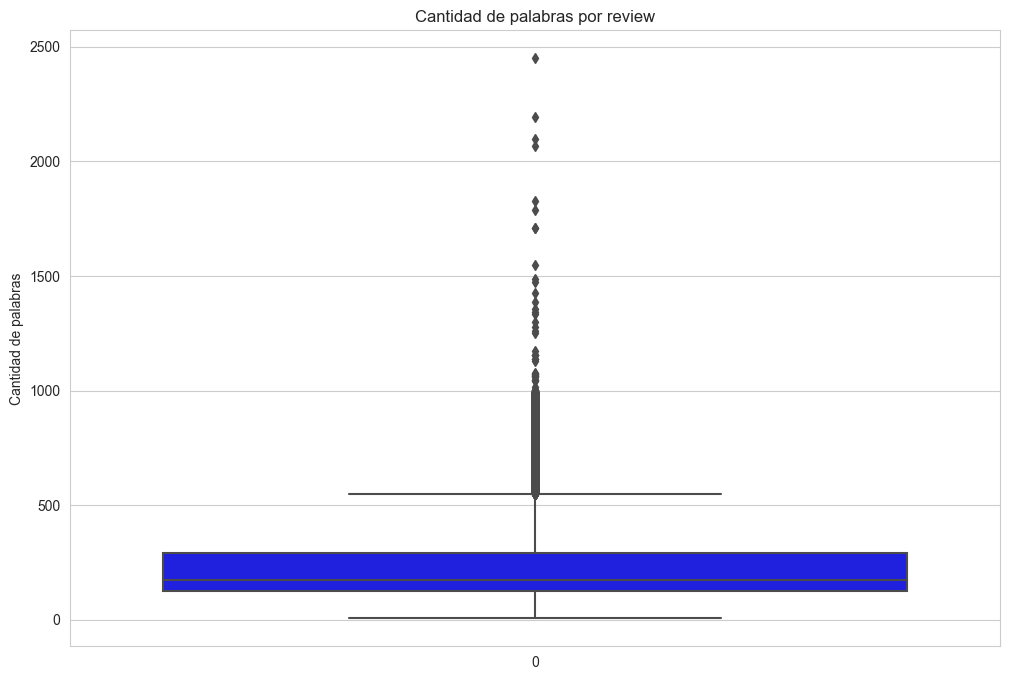

In [80]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
sns.boxplot(df['cantidad_de_palabras'], color='blue')
plt.ylabel('Cantidad de palabras')
plt.title('Cantidad de palabras por review')
plt.show()

Como se puede observar en el boxplot de arriba, contamos con bastantes outliers en la cantidad de palabras de las reviews. Por lo tanto, vamos a utilizar otras tecnicas como el z-score y z-score modificado para ver cuantas reviews serian consideradas outliers.

In [7]:
df['zscore'] = (df['cantidad_de_palabras'] - df['cantidad_de_palabras'].mean()) / df['cantidad_de_palabras'].std()

KeyError: 'cantidad_de_palabras'

In [82]:
df_z_score = df[(df['zscore'] > 3) | (df['zscore'] < -3)]
df_z_score.shape

(1240, 6)

In [6]:
mediana_cantidad_de_palabras=np.median(df['cantidad_de_palabras'])
MAD=np.median(np.absolute(df['cantidad_de_palabras']-mediana_cantidad_de_palabras))

df['zm_cantidad_de_palabras']=(df['cantidad_de_palabras'] - mediana_cantidad_de_palabras)*0.6745/MAD
df[np.absolute(df['zm_cantidad_de_palabras'] > 3.5)].shape

KeyError: 'cantidad_de_palabras'

In [5]:
sns.countplot(df[np.absolute(df['zm_cantidad_de_palabras'] > 3.5)]['sentimiento'])
plt.xlabel('Sentimiento')
plt.title('Cantidad de reviews positivos y negativos')
plt.show()

KeyError: 'zm_cantidad_de_palabras'

Por otro lado, creimos que tambien seria interesante ver como se distribuye la cantidad de palabras de las reviews en funcion de su sentimiento.

/Users/juampi/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/juampi/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/juampi/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


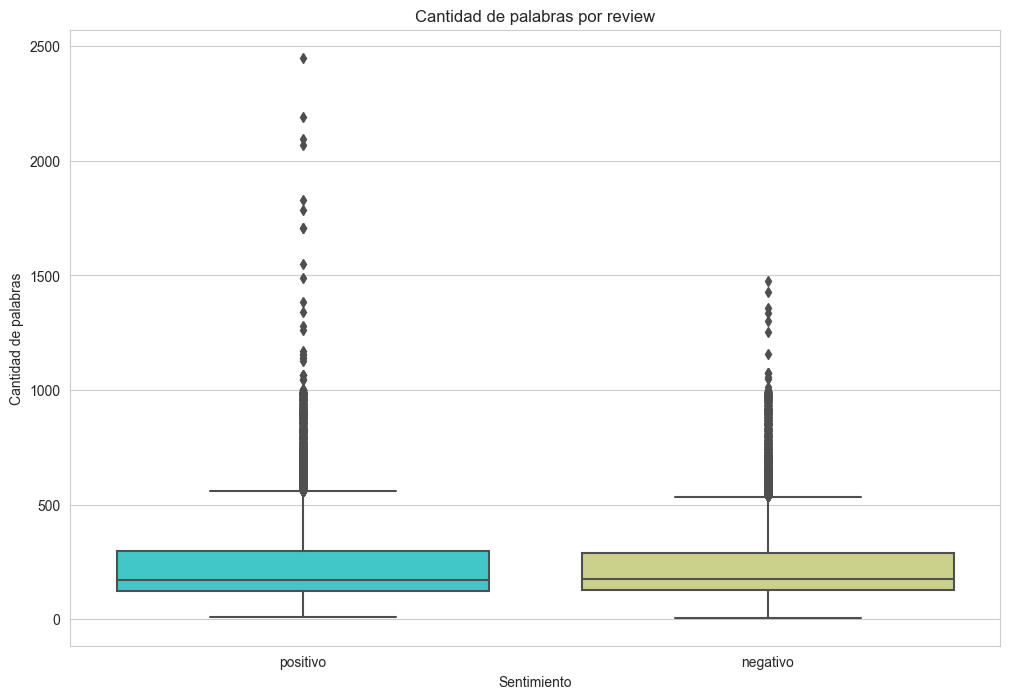

In [91]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
sns.boxplot(x='sentimiento', y='cantidad_de_palabras', data=df, palette='rainbow')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de palabras')
plt.title('Cantidad de palabras por review')
plt.show()

Dejando de lado a los outliers, se puede ver que la cantidad de palabras es muy pareja entre las reviews positivas y negativas.

Ademas, otro factor que creemos que puede ser importante es la cantidad de caracteres de las reviews. Por lo tanto, vamos a calcularlo por cada review. Esta informacion nos servira luego a la hora de traducir los reviews que no esten en castellano ya que la API de Google Translate tiene un limite de caracteres por request de 5000 caracteres.

In [92]:
df['longitud_review'] = df['review_es'].apply(lambda x: len(str(x)))
df['longitud_review'].describe()

count    50000.000000
mean      1398.058240
std       1037.688582
min         39.000000
25%        747.000000
50%       1037.000000
75%       1711.000000
max      13465.000000
Name: longitud_review, dtype: float64

/Users/juampi/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/juampi/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/juampi/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/juampi/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

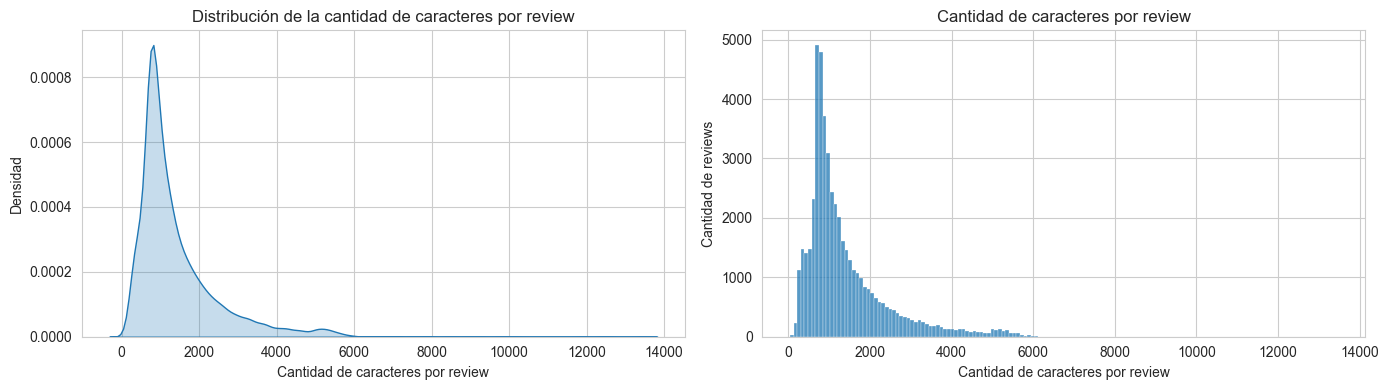

In [93]:
sns.set_style('whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

sns.kdeplot(df['longitud_review'], fill=True, ax=ax1).set_title('Distribución de la cantidad de caracteres por review')
ax1.set_ylabel('Densidad')
ax1.set_xlabel('Cantidad de caracteres por review')

sns.histplot(df['longitud_review'],  ax=ax2, bins=150, kde=False).set_title('Cantidad de caracteres por review')
ax2.set_xlabel('Cantidad de caracteres por review')
ax2.set_ylabel('Cantidad de reviews')

plt.tight_layout()
plt.show()

Luego, verificamos que no haya reviews duplicadas. En caso positivo, durante el preprocesamiento las eliminaremos.

In [94]:
df['review_es'].duplicated().sum()

401

Otro analisis importante es verificar si hay reviews que esten en otro idioma ya que distorsionarian fuertemente el analisis. En caso positivo, durante el preprocesamiento las intentaremos traducir al castellano. La otra opcion seria eliminarlas, veremos cual nos brinda mejores resultados.

In [95]:
if os.path.isfile('datasets/train_con_idioma.csv'):
    df = pd.read_csv('datasets/train_con_idioma.csv', sep=',')
else:
    df['idioma'] = df['review_es'].apply(detect)
df['idioma'].value_counts()

idioma
es    48180
en     1817
fr        1
it        1
id        1
Name: count, dtype: int64

In [96]:
if not os.path.isfile('datasets/train_con_idioma.csv'):
    df.to_csv('datasets/train_con_idioma.csv', index=False)

Tambien, vamos a verificar la cantidad de reviews que contienen numeros, ya que si esta entre 1 y 10, nos puede indicar informacion relevante de la puntuacion de la pelicula.

In [97]:
df['contiene_numeros'] = df['review_es'].str.contains(r'\d', regex=True)

conteo_contiene_numeros = df['contiene_numeros'].sum()

print(f"Cantidad de reseñas que contienen números: {conteo_contiene_numeros}")

Cantidad de reseñas que contienen números: 27609


Obesrevamos que la gran mayoria de reviews contienen numeros.

Ahora vamos a graficar la cantidad de reviews que contienen numeros de nuestro interes. Osea, puntuaciones posibles entre 0 y 10 ya que creemos que mas tarde nos puede aportar informacion extra para el modelo.

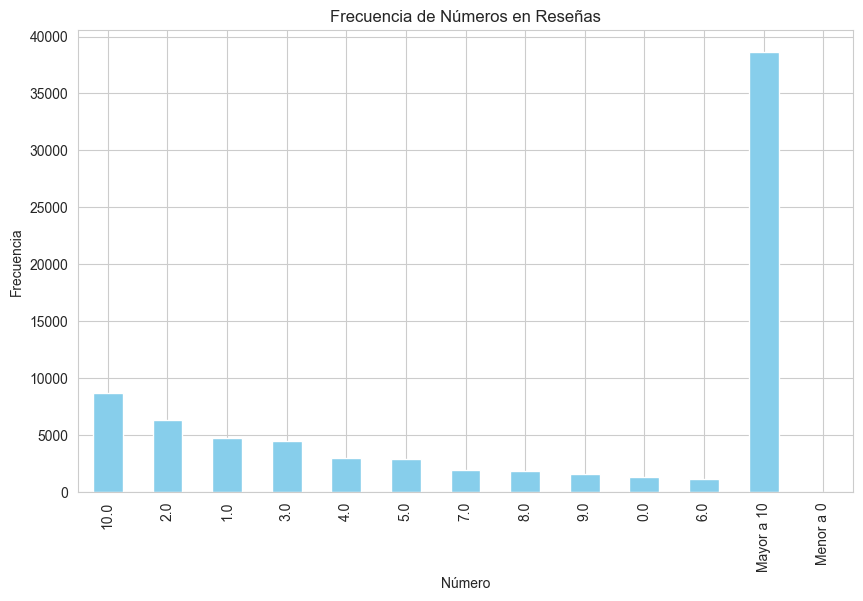

In [98]:
df['numeros_en_review'] = df['review_es'].str.extractall(r'(\d+)').astype(float).groupby(level=0)[0].apply(list)

todos_los_numeros = [numero for lista_numeros in df['numeros_en_review'].dropna() for numero in lista_numeros]

frecuencia_numeros = pd.Series(todos_los_numeros).value_counts()

frecuencia_filtrada = frecuencia_numeros[(frecuencia_numeros.index.astype(int) >= 0) & (frecuencia_numeros.index.astype(int) <= 10)]
mejores_valores = frecuencia_numeros[(frecuencia_numeros.index.astype(int) > 10)].sum()
peores_valores = frecuencia_numeros[(frecuencia_numeros.index.astype(int) < 0)].sum()
frecuencia_filtrada['Mayor a 10'] = mejores_valores
frecuencia_filtrada['Menor a 0'] = peores_valores

plt.figure(figsize=(10, 6))
frecuencia_filtrada.plot(kind='bar', color='skyblue')
plt.title('Frecuencia de Números en Reseñas')
plt.xlabel('Número')
plt.ylabel('Frecuencia')
plt.show()

Como se puede ver, hay una gran cantidad de reviews con numeros de nuestro interes, es por esto que vamos a indagar mas profundamente para ver si nos provee informacion relevante.

/Users/juampi/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/juampi/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/juampi/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/juampi/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

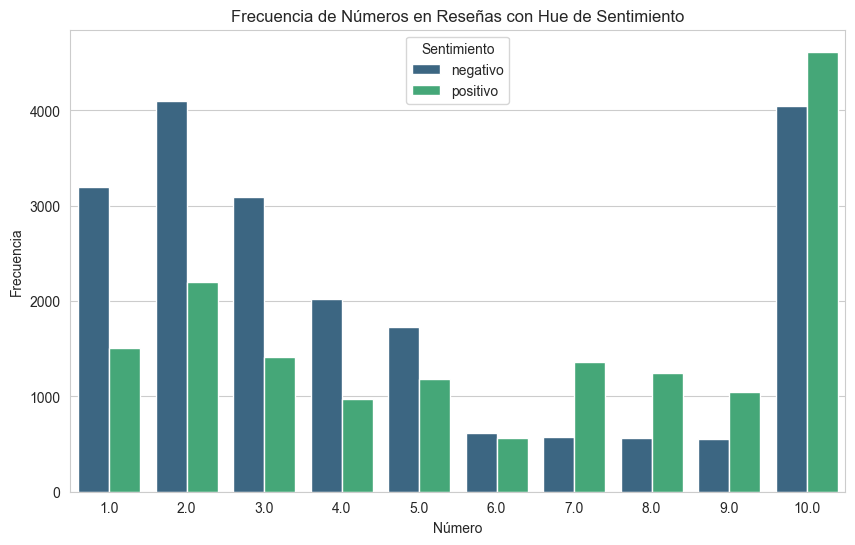

In [99]:
def extraer_numeros_y_sentimiento(texto, sentimiento):
    numeros = re.findall(r'(\d+)', texto)
    return [(int(numero), sentimiento) for numero in numeros]

df_numeros_sentimientos = df.apply(lambda row: extraer_numeros_y_sentimiento(row['review_es'], row['sentimiento']), axis=1).explode()

df_numeros_sentimientos = pd.DataFrame(list(df_numeros_sentimientos), columns=['numero', 'sentimiento'])

frecuencia_filtrada = df_numeros_sentimientos[(df_numeros_sentimientos['numero'] >= 1) & (df_numeros_sentimientos['numero'] <= 10)]
otros_valores = df_numeros_sentimientos[(df_numeros_sentimientos['numero'] < 1) | (df_numeros_sentimientos['numero'] > 10)].groupby('sentimiento').size().reset_index(name='count')
frecuencia_filtrada = frecuencia_filtrada.groupby(['numero', 'sentimiento']).size().reset_index(name='count')
frecuencia_filtrada = pd.concat([frecuencia_filtrada, otros_valores], ignore_index=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='numero', y='count', hue='sentimiento', data=frecuencia_filtrada, palette='viridis')
plt.title('Frecuencia de Números en Reseñas con Hue de Sentimiento')
plt.xlabel('Número')
plt.ylabel('Frecuencia')
plt.legend(title='Sentimiento')
plt.show()

Podemos ver que como se esperaba, en la mayoria de los numeros tiene un sentimiento acorde a su valor, exceptuando 10 que tiene un sentimiento muy parejo. Esto realmente nos sorprendio.

Por ultimo, vamos a verificar la cantidad total de palabras unicas en nuestro dataset antes del preprocesamiento. Luego del preprocesamiento, esperamos que esta cantidad disminuya considerablemente, haciendo que nuestros modelos se entrenen mas rapido y tengan mejor performance.

In [100]:
tokens = []
for review in df['review_es']:
    tokens.extend(review.split())

palabras_unicas = set(tokens)
numero_de_palabras_unicas = len(palabras_unicas)

print("Numero de palabras unicas en el dataset pre preprocesamiento:", numero_de_palabras_unicas)

Numero de palabras unicas en el dataset pre preprocesamiento: 559112


## Preprocesamiento

Comenzamos eliminando los duplicados identificados anteriormente ya que no nos aportan informacion adicional.

In [101]:
df = df.drop_duplicates(subset=['review_es'])
df.shape

(49599, 10)

Antes de borrar las reviews que esten en otro idioma, veremos si el idioma nos brinda alguna informacion en el sentimiento.

/Users/juampi/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/juampi/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/juampi/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/juampi/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

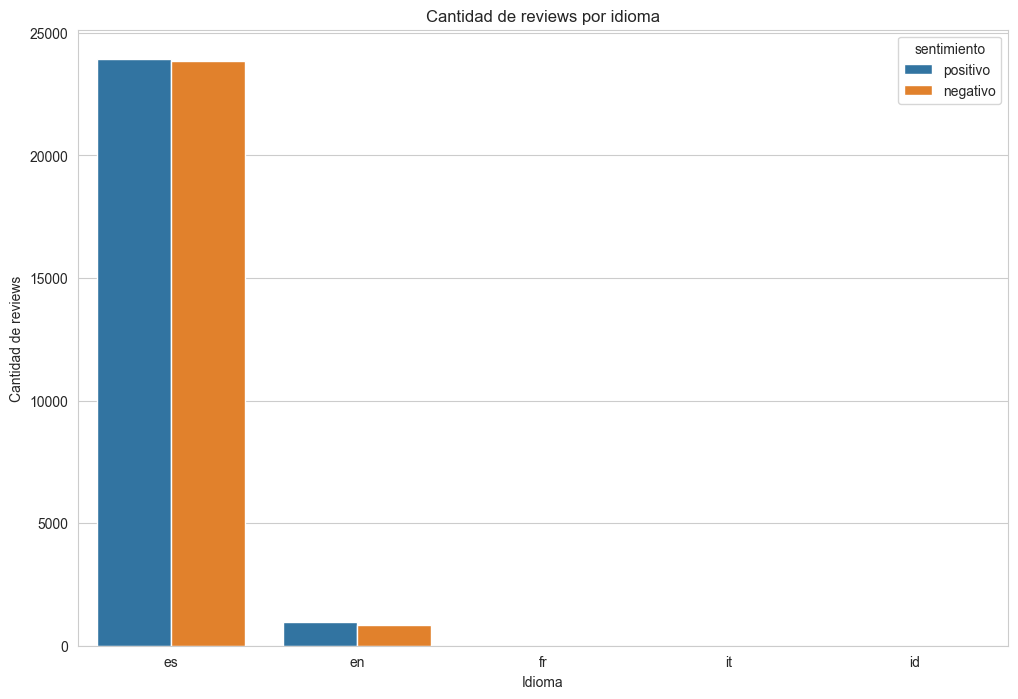

In [102]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
sns.countplot(x='idioma', hue='sentimiento', data=df)
plt.xlabel('Idioma')
plt.ylabel('Cantidad de reviews')
plt.title('Cantidad de reviews por idioma')

plt.show()

Como la distribucion de sentimientos es bastante pareja, y teniendo en cuenta que con la traduccion nuestros modelos empeoraban su performance, elegimos eliminar las reviews que no esten en castellano.

In [103]:
df = df[df['idioma'].isin(['es'])]
df['idioma'].value_counts()

idioma
es    47782
Name: count, dtype: int64

Como pudimos ver anteriormente, existen unas reviews las cuales contienen emojis pero a pesar de que sean muy pocos igualmente vamos a convertirlos a texto.

In [104]:
df['review_es'] = df['review_es'].apply(demojize)

In [105]:
df['tiene_emoji'] = df['review_es'].apply(emoji_count)
cantidad_emojis = df['tiene_emoji'].value_counts().reset_index()
cantidad_emojis.columns = ['cantidad_emojis', 'cantidad_filas']
cantidad_emojis

,cantidad_emojis,cantidad_filas
0,0,47782


Teniendo los emojis convertidos a texto podemos continuar trabajando con el dataset

A continuacion, vamos a eliminar todas las reviews que tengan el z-score mayor a 3 en modulo. Decidimos tener en cuenta este metodo ya que luego de utilizar ambos, sorprendentemente el z-score nos dio mejores resultados. Quizas se deba a que el z-score modificado es mas agresivo a la hora de eliminar outliers, dejandonos con bastante menos data para entrenar los modelos.

In [106]:
df = df[np.absolute(df['zscore'] < 3)]
df.shape

(47120, 11)

Con esto, eliminamos casi un 5% de samples del dataset original, entre los duplicados, las reviews que no estaban en castellano y las que tenian un z-score mayor a 3 en modulo.

Veremos como se comportan los campos analizados previamente luego del preprocesamiento.

TypeError: boxplot() got an unexpected keyword argument 'fill'

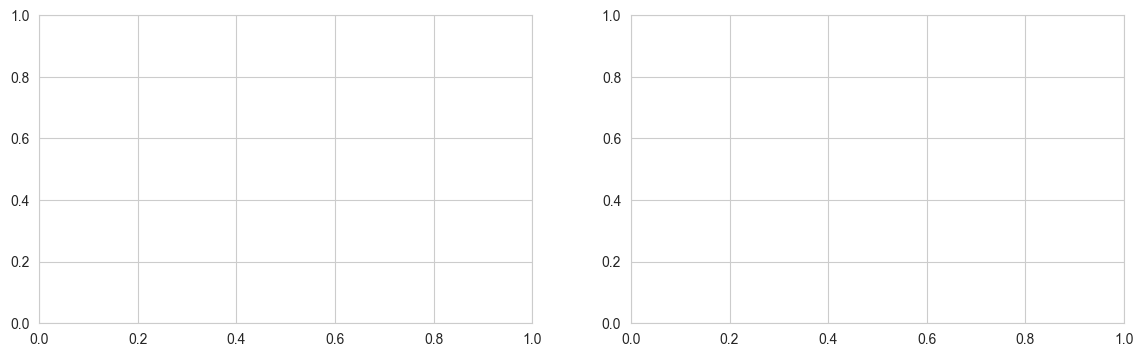

In [107]:
sns.set_style('whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

sns.boxplot(df['cantidad_de_palabras'], fill=True, ax=ax1).set_title('Distribución de la cantidad de palabras por review')
ax1.set_ylabel('Cantidad reviews')
ax1.set_xlabel('Cantidad de palabras')

sns.histplot(df['longitud_review'],  ax=ax2, bins=150, kde=False).set_title('Cantidad de caracteres por review')
ax2.set_xlabel('Cantidad de caracteres por review')
ax2.set_ylabel('Cantidad de reviews')

plt.tight_layout()
plt.show()

In [108]:
df['longitud_review'].describe()

count    47120.000000
mean      1303.951677
std        843.374861
min         39.000000
25%        744.000000
50%       1020.000000
75%       1638.000000
max       4958.000000
Name: longitud_review, dtype: float64

Ademas, eliminando los samples que indicaba el z-score seguimos aptos para traducir las reviews ya que no superamos el limite de caracteres por request de la API de Google Translate.

/Users/juampi/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/juampi/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/juampi/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Cantidad de palabras por review')

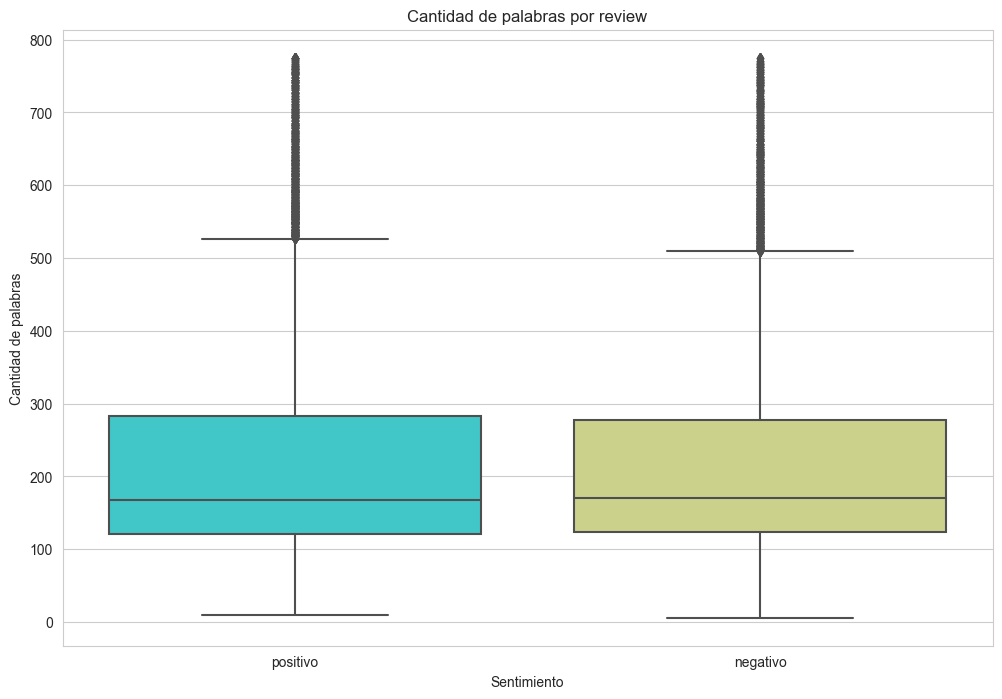

In [109]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
sns.boxplot(x='sentimiento', y='cantidad_de_palabras', data=df, palette='rainbow')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de palabras')
plt.title('Cantidad de palabras por review')

Ademas, vamos a analizar que luego de la eliminacion de estos reviews nos quede una distribucion parecida de samples positivos y negativos.

In [110]:
sns.countplot(df['sentimiento'])
plt.xlabel('Label')
plt.title('Cantidad de reviews positivos y negativos')
plt.show()

ValueError: could not convert string to float: 'positivo'

La cantidad sigue siendo bastante pareja, por lo tanto, podemos continuar con el preprocesamiento.

Como habiamos mencionado anteriormente, aca esta la idea de como traducir las reviews que no esten en castellano. Para ello, vamos a utilizar la API de Google Translate. Sin embargo, no lo utilizaremos ya que luego de haber experimentado con esta idea, vimos que empeora la performance de los modelos.

In [ ]:
from deep_translator import GoogleTranslator

def traducir_al_castellano(texto, idioma):
    traduccion = GoogleTranslator(source='english', target='spanish').translate(texto)
    return traduccion

if not os.path.isfile('datasets/train_con_traduccion.csv'):
    for index, row in df.iterrows():
        if row['idioma'] == 'en':
            df.loc[index, 'review_es'] = traducir_al_castellano(row['review_es'],'en' )
    df.to_csv('datasets/train_con_traduccion.csv', index=False)
else:
    df = pd.read_csv('datasets/train_con_traduccion..csv', sep=',')

NotValidLength: From the film's first shot - Keira Knightley as Elizabeth Bennet wandering reading through a field at dawn, thus invoking all the clichés cinema has developed to address the phenomenon of the strong-minded rebellious female character in period drama - I knew I was in for something to make me want to kill myselfJoe Wright seemed not only to have not read the book, but to be under the regrettable misapprehension that what he was filming was not in fact Jane Austen's subtle, nuanced comedy of manners conducted through sparkling, delicate social interaction in eighteenth century English drawing-rooms, but a sort of U-certificate Wuthering Heights Thus we were treated to every scene between Elizabeth and Darcy taking place outside for no apparent reason, in inappropriately rugged scenery and often in the pouring rain Not to mention that Jane Austen, and in particular P & P, is not about passion, sexual tension or love It's about different strategies of negotiating the stultification of eighteenth century society Which was completely ignored, so that the Bennets' house was a rambunctious, chaotic place where everybody shouts at once, runs around, leaves their underwear on chairs, and pigs wander happily through the house; the society balls become rowdy country dances one step away from a Matrix Reloaded style dance-orgy; and everybody says exactly what they think without the slightest regard for proprietyThe genius of Jane Austen lies in exploring the void created by a society in which nobody says what they think or mean because of an overwhelming regard for propriety, and the tragic predicaments of her characters arise from misunderstandings and miscommunications enabled by that speechless gap So both the brilliance of Jane Austen and the very factor that allows her plots - particularly in this film - to function was completely erased Subtlety in general was nowhere int his film, sacrificed in favour of an overwrought drama which jarred entirely with the material and the performancesIt was so obviously trying to be a *serious* film The humour - which IS Pride & Prejudice, both Austen's methodology and her appeal - was almost entirely suppressed in favour of all this po-faced melodrama, and when it was allowed in, was handled so clumsily Pride & Prejudice is a serious narrative which makes serious points, yes, but those serious points and weightier themes are not just intertwined with the humour, they are embedded in it You can't lose Jane Austen's technique, leaving only the bare bones of the story, and expect the themes to remain Not even when you replace her techniques with your own heavy-handed mystical-numinous fauxbrow cinematographyElizabeth Bennett is supposed to be a woman, an adult, mature and sensible and clear-sighted Keira Knightley played the first half of the film like an empty-headed giggling schoolgirl, and the second half like an empty-headed schoolgirl who thinks she is a tragic heroine Elizabeth's wit, her combative verbal exchanges, her quintessential characteristic of being able to see and laugh at everybody's follies including her own, her strength and composure, and her fantastic clear-sightedness were completely lost and replaced with  what? A lot of giggling and staring into the distance? Rather than being able to keep her head when all about her were losing theirs, she started to cry and scream at the slightest provocation - and not genuinely raging, either; no, these were petulant hissy fits And where the great strength of Austen's Elizabeth (at least in Austen's eyes) was her ability to retain integrity and observance while remaining within the boundaries of society and sustaining impeachable propriety, Knightley's Elizabeth had no regard whatsoever for convention Furthermore, she seemed to think that wandering around barefoot in the mud in the eighteenth century version of overalls established her beyond doubt as spirited and strong-minded, and therefore nothing in the character as written or the performance had to sustain it An astonishingly unsubtle and bland performance In which quest for blandness and weakness, she was ably matched by Matthew MacfaydenDonald Sutherland as Mr Bennet seemed weak, ineffectual and permanently befuddled without the wicked sense of humour and ironic detachment at the expense of human relationships that makes Mr Bennet so fascinating and tragic His special bond with Lizzie, as the only two sensible people in a world of fools, was completely lost, not least because both of them were fools in a world of fools, and that completely deprived the end of the film of emotional impact Mr Bingley was no longer amiable and well-meaning to the point of folly, but was played as a complete retard for cheap laughs, and the woman who was playing Jane was so wildly inconsistent that she may as well not have tried to do anything with the character at all The script veered wildly between verbatim chunks of Jane Austen - delivered with remarkable clumsiness - and totally contemporaneous language which would not be out of place in a modern day romantic comedyJust get the BBC adaptation on DVD and save yourself the heartache --> Text length need to be between 0 and 5000 characters

A continuacion realizaremos un paso muy importante en este tp, el cual va a reducir el tiempo de entrenaminto de los modelos, va a mejorar su performance y va a evitar que los modelos se sobreajusten. Este paso es el preprocesamiento de las reviews.

Los pasos a realizar son los siguientes:

- limpiar texto = Elimina los caracteres que no sean un caracter alfanumerico y los reemplaza por espacios en blanco. Elimina las palabras que tienen solo un carácter alfabético y las reemplaza por espacios en blanco. Sustituye múltiples espacios en blanco por uno solo. Convierte todos los caracteres del texto a minúsculas.

- filtrar stopwords = elimina las stopwords que son palabras comunes sin significado específico.

- stem palabras = reduce cada token a su raíz (o "stem").

- tokenize = realiza una serie de operaciones de preprocesamiento (las mencionadas anteriormente y tambien elimina los sustantivos propios) y devuelve el texto tokenizado y procesado.

In [111]:
df_preprocesado = df.copy()

nlp = spacy.load("es_core_news_sm")

tokenizer = ToktokTokenizer() 
STOPWORDS = set(stopwords.words("spanish"))
stemmer = nltk.stem.SnowballStemmer("spanish")

def limpiar_texto(texto):
    # Eliminamos los caracteres especiales
    texto = re.sub(r'\W', ' ', str(texto))
    # Eliminado las palabras que tengo un solo caracter
    texto = re.sub(r'\s+[a-zA-Z]\s+', ' ', texto)
    # Sustituir los espacios en blanco en uno solo
    texto = re.sub(r'\s+', ' ', texto, flags=re.I)
    # Convertimos textos a minúsculas
    texto = texto.lower()
    return texto

def filtrar_stopword_digitos(tokens):
    return [token for token in tokens if token not in STOPWORDS and not token.isdigit()]

def stem_palabras(tokens):
    return [stemmer.stem(token) for token in tokens]

def tokenize(texto):
    text_cleaned = limpiar_texto(texto)
    doc = nlp(text_cleaned)
    
    tokens = [token.text for token in doc if token.pos_ != 'PROPN' and len(token.text) > 1]
    tokens = filtrar_stopword_digitos(tokens)
    stems = stem_palabras(tokens)
    stems = ' '.join(stems)
    return stems

OSError: [E050] Can't find model 'es_core_news_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

Tambien decidimos eliminar los numeros, ya que incluyendo todos los modelos empeoraban su performance. Ademas, probamos manteniendo los numeros que estaban entre 0 y 10 pero tampoco ayudo.

Aca preprocesamos todas las reviews con los pasos mencionados anteriormente.

In [ ]:
df_preprocesado['review_es'] = df_preprocesado['review_es'].apply(tokenize)

In [112]:
nombre_df_exportar = 'datasets/train_preprocesado_sin_traduccion_z_score.csv'
if not os.path.isfile(nombre_df_exportar):
    df_preprocesado.to_csv(nombre_df_exportar, index=False)

Utilizameros el dataset ya preprocesado sin traducciones, o sea, que elimina las reviews que no estaban en castellano. Ademas, elimina los outliers marcados por el z-score y los sustantivos propios. Esto lo hicimos para ahorrarnos tiempo de ejecucion ya que tenemos frecuentemente crasheos del kernel.

In [113]:
nombre_df = 'datasets/train_preprocesado_sin_traduccion_z_score_sin_propper_nouns.csv'
df_preprocesado = pd.read_csv(nombre_df, sep=',')

Con esto podemos observar brevemente como quedan las reviews luego de este preprocesamiento.

In [114]:
df_preprocesado.head(10)

,ID,review_es,sentimiento,cantidad_de_palabras,zscore,zm_cantidad_de_palabras,longitud_review,idioma
0,0,critic mencion despues ver sol oz episodi enga...,positivo,345,0.600271,1.823258,2004,es
1,1,pequeñ pequeñ produccion tecnic filmacion incu...,positivo,161,-0.424631,-0.115930,1061,es
2,2,pens maner maravill pas tiemp fin seman veran ...,positivo,173,-0.357789,0.010539,989,es
3,3,basic famili niñ pequeñ piens zombi armari pad...,negativo,137,-0.558314,-0.368867,790,es
4,4,amor tiemp pett mattei pelicul visual impresio...,positivo,237,-0.001302,0.685039,1406,es
5,5,probabl pelicul favorit tiemp histori desinter...,positivo,123,-0.636295,-0.516414,724,es
6,6,segur gust ver resurreccion seri tecnolog hoy ...,positivo,157,-0.446911,-0.158086,839,es
7,7,espectacul ide increibl fresc innov años emit ...,negativo,168,-0.385640,-0.042156,1034,es
8,8,alent comentari posit pelicul aqu des ver peli...,negativo,120,-0.653006,-0.548031,708,es
9,9,si gust ris original desgarr gust pelicul si j...,positivo,31,-1.148747,-1.486008,186,es


In [115]:
tokens = []
for review in df_preprocesado['review_es']:
    tokens.extend(review.split())

palabras_unicas = set(tokens)
numero_de_palabras_unicas = len(palabras_unicas)

print("Numero de palabras unicas en el dataset post preprocesamiento:", numero_de_palabras_unicas)

Numero de palabras unicas en el dataset post preprocesamiento: 73046


Se puede observar que el preprocesamiento disminuyo notablemente nuestro bag of words.

Como ultimo paso del preprocesamiento, dividimos el dataset en train y test. Utilizamos un ratio de 80% para train y 20% para test. Ademas, utilizamos el parametro random_state para que la division sea reproducible. Tambien trasladamos los labels a valores numericos para poder trabajar con ellos.

In [155]:
df_preprocesado['sentimiento'] = df_preprocesado['sentimiento'].map({'negativo': 0, 'positivo': 1, 0: 0, 1: 1})

x_train, x_test, y_train, y_test = train_test_split(df_preprocesado['review_es'], df_preprocesado['sentimiento'], test_size=0.2, random_state=42)

## Entrenamiento de modelos

Cabe recalcar que para cada modelo utilizamos CountVectorizer y TfidfVectorizer para ver cual nos brindaba mejores resultados. Solo mantenemos el que mejor performance nos brindo. Ademas, utilizamos RandomizedSearchCV para encontrar los mejores hiperparametros para los modelos principales. Ademas, las busquedas de hiperparetros estaran con baja cantidad de iteraciones ya que las corridas largas fueron realizadas previamente.

### Modelos de Bayes Naïve

#### Bayes Naïve Multinomial

Vamos a probar en primer lugar con un count vectorizer y luego con un tfidf vectorizer par ver con cual obtenemos mejores resultados

In [117]:
modelo_count = make_pipeline(CountVectorizer(), MultinomialNB())
modelo_tfidf = Pipeline([('tvec', TfidfVectorizer()), ('mnb',MultinomialNB())])

In [118]:
modelo_count.fit(x_train, y_train)
prediccion_count = modelo_count.predict(x_test)

mostrar_scores(y_test, prediccion_count)

Accuracy: 0.8544142614601019
Recall: 0.8460391822827938
Precision: 0.8595845954132411
f1 score: 0.8527581025971239


In [119]:
modelo_tfidf.fit(x_train, y_train)
prediccion_tfidf = modelo_tfidf.predict(x_test)

mostrar_scores(y_test, prediccion_tfidf)

Accuracy: 0.8542020373514432
Recall: 0.8517887563884157
Precision: 0.8550662676357418
f1 score: 0.8534243652656284


En este caso, dio mejores resultados el count vectorizer. Sin embargo, por investigaciones nuestras, creemos que el tfidf es superior para este tipo de problemas. De todas maneras, por cada modelo vamos a probar los dos quedandonos con el mejor, tal como dijimos anteriormente.

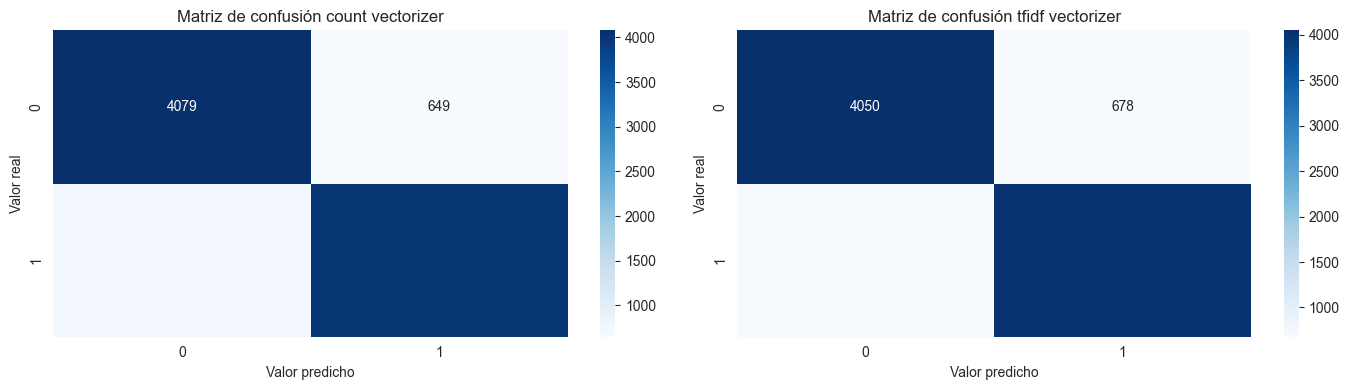

In [120]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

matriz_confusion = confusion_matrix(y_test, prediccion_count)
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', ax=ax1).set_title('Matriz de confusión count vectorizer')
ax1.set_xlabel('Valor predicho')
ax1.set_ylabel('Valor real')

matriz_confusion = confusion_matrix(y_test, prediccion_tfidf)
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', ax=ax2).set_title('Matriz de confusión tfidf vectorizer')
ax2.set_xlabel('Valor predicho')
ax2.set_ylabel('Valor real')

plt.tight_layout()
plt.show()

Podemos ver que en que en ambos casos nuestro modelo tiende a predecir a una review como negativa. Es por esto que la metrica de recall se ve tan baja comparada a la precision.

In [121]:
prediccion_count_train = modelo_count.predict(x_train)
prediccion_tfidf_train = modelo_tfidf.predict(x_train)

print("Prediccion en train con count vectorizer")
mostrar_scores(y_train, prediccion_count_train)
print("----------------------------------------")
print("Prediccion en train con tfidf vectorizer")
mostrar_scores(y_train, prediccion_tfidf_train)

Prediccion en train con count vectorizer
Accuracy: 0.89526740237691
Recall: 0.8826830430409233
Precision: 0.9058951371909807
f1 score: 0.894138467313777
----------------------------------------
Prediccion en train con tfidf vectorizer
Accuracy: 0.8950286502546689
Recall: 0.8863889035946847
Precision: 0.902393014983292
f1 score: 0.894319365435462


Notamos que en ambos casos, nuestro modelo esta overfitteado.

Vamos a resolver este limitando la cantidad de features que utiliza el modelo. Para ello, vamos a utilizar el parametro max_features del vectorizer. De ahora en mas continuaremos solo con el count vectorizer ya que obtuvimos mejores resultados con el en este unico caso.

In [122]:
vectorizer = CountVectorizer(max_features=6000)
modelo_tfidf = make_pipeline(vectorizer, MultinomialNB(alpha=0.1))
modelo_tfidf.fit(x_train, y_train)

prediccion = modelo_tfidf.predict(x_test)

mostrar_scores(y_test, prediccion)

Accuracy: 0.8504881154499151
Recall: 0.8522146507666098
Precision: 0.8484206063175748
f1 score: 0.8503133963667268


In [123]:
prediccion_train = modelo_tfidf.predict(x_train)

mostrar_scores(y_train, prediccion_train)

Accuracy: 0.8539632852292021
Recall: 0.8505479379533062
Precision: 0.8569447407723491
f1 score: 0.8537343571485506


Con esto, podemos ver que nuestro modelo mantuvo su performance. Ademas, podemos ver que ya no esta overfitteado.

#### Bayes Naive Multinomial con bigramas

Este modelo tienen en cuenta la cantidad de apariciones de cada palabra. 

Ahora vamos a probar una variante interesante la cual consiste en usar unigramas y bigramas. Para ello, vamos a utilizar el parametro ngram_range del vectorizer. 

In [124]:
vectorizer = TfidfVectorizer(max_features=25000, ngram_range=(1, 2), min_df=5, max_df=0.7, norm='l1')
modelo_bigramas = make_pipeline(vectorizer, MultinomialNB(alpha=0.5))
modelo_bigramas.fit(x_train, y_train)

prediccion = modelo_bigramas.predict(x_test)

mostrar_scores(y_test, prediccion)

Accuracy: 0.8729838709677419
Recall: 0.9028960817717206
Precision: 0.8512346918289501
f1 score: 0.8763046398677278


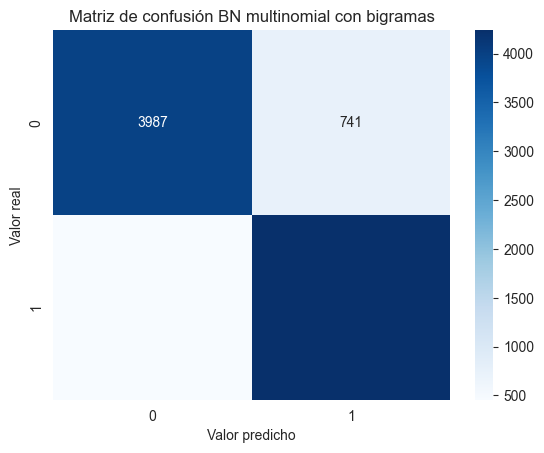

In [125]:
matriz_confusion = confusion_matrix(y_test, prediccion)
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues').set_title('Matriz de confusión BN multinomial con bigramas')
plt.xlabel('Valor predicho')
plt.ylabel('Valor real')
plt.show()

In [126]:
prediccion_train = modelo_bigramas.predict(x_train)

mostrar_scores(y_train, prediccion_train)


Accuracy: 0.8911025042444821
Recall: 0.9179416591667108
Precision: 0.8715693173821253
f1 score: 0.8941546553902483


Notamos una gran mejoria en la metrica de recall, lo cual es muy bueno ya que nuestro modelo ahora esta prediciendo mejor las reviews negativas. Sin embargo, la metrica de precision disminuyo un poco. El lado positivo es que nuestro modelo sigue sin estar overfitteado.

In [ ]:
pickle.dump(modelo_bigramas, open('modelos/bayes_naive_multinomial.pkl', 'wb'))

#### Bayes Naive Gausseano

In [127]:
vectorizer = TfidfVectorizer(max_features=2000)
modelo_gauss = make_pipeline(vectorizer, DenseTransformer(), GaussianNB())
modelo_gauss.fit(x_train, y_train)

prediccion = modelo_gauss.predict(x_test)

mostrar_scores(y_test, prediccion)

Accuracy: 0.79223259762309
Recall: 0.8002555366269165
Precision: 0.7865215571368773
f1 score: 0.7933291112518472


In [128]:
prediccion_train = modelo_gauss.predict(x_train)

mostrar_scores(y_train, prediccion_train)

Accuracy: 0.8044354838709677
Recall: 0.8038011541108582
Precision: 0.8055069234442146
f1 score: 0.8046531347713181


Notamos que los resultados de este tipo de modelo son muy pobres comparado a los anteriores. Es por ello que no vamos probarlo en profundidad.

#### Bayes Naive Bernoulli

Este modelo a diferencia del multinomial, solo tiene en cuenta si una palabra ocurre o no.

Aca decidimos experimentar mas en profundidad los parametros del vectorizer. Nos vamos a quedar con los que mejor resultados nos dieron.

In [129]:
vectorizer = TfidfVectorizer(max_features=25000, ngram_range=(1, 2), min_df=5, max_df=0.7, binary=True)
modelo_bernoulli = make_pipeline(vectorizer, BernoulliNB( alpha=0.5
))
modelo_bernoulli.fit(x_train, y_train)

prediccion = modelo_bernoulli.predict(x_test)

mostrar_scores(y_test, prediccion)

Accuracy: 0.8729838709677419
Recall: 0.9005536626916525
Precision: 0.8527929017947167
f1 score: 0.8760227861211807


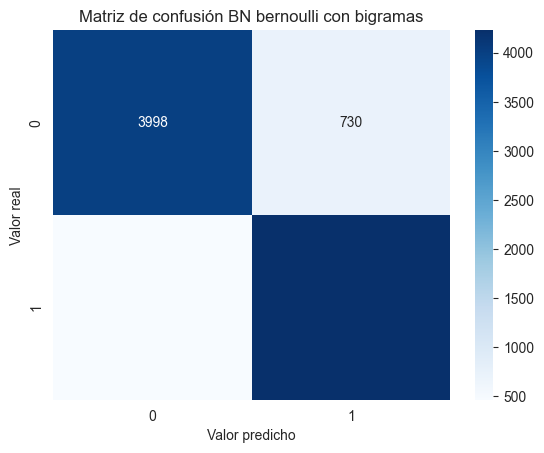

In [130]:
matriz_confusion = confusion_matrix(y_test, prediccion)
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues').set_title('Matriz de confusión BN bernoulli con bigramas')
plt.xlabel('Valor predicho')
plt.ylabel('Valor real')
plt.show()

In [131]:
prediccion_train = modelo_bernoulli.predict(x_train)

mostrar_scores(y_train, prediccion_train)

Accuracy: 0.8916861205432938
Recall: 0.9167240192704749
Precision: 0.8733985675375769
f1 score: 0.8945370011623401


In [ ]:
pickle.dump(modelo_bernoulli, open('modelos/bayes_naive_bernoulli.pkl', 'wb'))

Aqui podemos observar otro gran modelo a tener en cuenta ya que obtuvimos muy buenos resultados. El aspecto positivo de estos modelos de Bayes Naive es que son muy rapidos de entrenar y de predecir.

#### Busqueda de hiperparametros

En este caso la busqueda va a ser bastante simple ya que este modelo no tiene muchos hiperparametros para tunear.

In [132]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), min_df=5, max_df=0.7, binary=True)
X = vectorizer.fit_transform(df_preprocesado['review_es'])
y = df_preprocesado['sentimiento'].map({'negativo': 0, 'positivo': 1, 0: 0, 1: 1})

modelo_multinomial_BN = BernoulliNB()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

n_iter = 1
param_grid = {'alpha': [0.1, 1.5, 2.0],
                'fit_prior': [True, False]}
random_search = RandomizedSearchCV(modelo_multinomial_BN, param_grid, n_iter=n_iter, cv=cv, scoring='f1', n_jobs=-1, verbose=3, random_state=42)
random_search.fit(X, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 5/5] END .........alpha=0.1, fit_prior=True;, score=0.862 total time=   0.3s
[CV 1/5] END .........alpha=0.1, fit_prior=True;, score=0.865 total time=   0.3s
[CV 2/5] END .........alpha=0.1, fit_prior=True;, score=0.865 total time=   0.3s
[CV 4/5] END .........alpha=0.1, fit_prior=True;, score=0.870 total time=   0.3s
[CV 3/5] END .........alpha=0.1, fit_prior=True;, score=0.860 total time=   0.3s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=BernoulliNB(), n_iter=1, n_jobs=-1,
                   param_distributions={'alpha': [0.1, 1.5, 2.0],
                                        'fit_prior': [True, False]},
                   random_state=42, scoring='f1', verbose=3)

In [133]:
print("Mejor estimador: ")
print(random_search.best_estimator_)
print("Mejor score: ")
print(random_search.best_score_)
print("Mejores parametros: ")
print(random_search.best_params_)

Mejor estimador: 
BernoulliNB(alpha=0.1)
Mejor score: 
0.864337103875562
Mejores parametros: 
{'fit_prior': True, 'alpha': 0.1}


#### Busqueda de hiperparametros de TFIDF

Observamos tanto en local como en los resultados de kaggle que los parametros del tfidf vectorizer afectan mucho a la performance de los modelos. Es por ello que vamos a realizar una busqueda de hiperparametros para el tfidf vectorizer.

In [134]:
vectorizer = TfidfVectorizer(binary=True, ngram_range=(1, 2))
modelo_multinomial_BN_random = BernoulliNB()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

n_iter = 1
pipe = Pipeline([('vectorizer', vectorizer), ('modelo', modelo_multinomial_BN_random)])

param_grid = {'vectorizer__max_features': [10000, 20000, 30000, 50000],
              'vectorizer__min_df': [5, 10, 15],
              'vectorizer__max_df': [0.7, 0.8, 0.9],
              'modelo__alpha': list(np.linspace(0.1, 1, num=10)),
              'modelo__fit_prior': [True, False]}

random_search = RandomizedSearchCV(pipe, param_grid, n_iter=n_iter, cv=cv, scoring='f1', n_jobs=-1, verbose=3, random_state=42)

random_search.fit(x_train, y_train)

print("Mejor estimador: ")
print(random_search.best_estimator_)
print("Mejor score: ")
print(random_search.best_score_)

print("Mejores parametros: ")
print(random_search.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 2/5] END modelo__alpha=0.2, modelo__fit_prior=True, vectorizer__max_df=0.9, vectorizer__max_features=30000, vectorizer__min_df=5;, score=0.872 total time=  11.8s
[CV 3/5] END modelo__alpha=0.2, modelo__fit_prior=True, vectorizer__max_df=0.9, vectorizer__max_features=30000, vectorizer__min_df=5;, score=0.865 total time=  12.0s
[CV 5/5] END modelo__alpha=0.2, modelo__fit_prior=True, vectorizer__max_df=0.9, vectorizer__max_features=30000, vectorizer__min_df=5;, score=0.871 total time=  12.2s
[CV 1/5] END modelo__alpha=0.2, modelo__fit_prior=True, vectorizer__max_df=0.9, vectorizer__max_features=30000, vectorizer__min_df=5;, score=0.874 total time=  12.0s
[CV 4/5] END modelo__alpha=0.2, modelo__fit_prior=True, vectorizer__max_df=0.9, vectorizer__max_features=30000, vectorizer__min_df=5;, score=0.871 total time=  11.9s
Mejor estimador: 
Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(binary=True, max_df=0.9, max_

#### Predicción en los datos de test para kaggle

In [ ]:
df_test = pd.read_csv('datasets/test.csv', sep=',')
df_test_procesado = df_test.copy()

df_test_procesado['review_es'] = df_test_procesado['review_es'].apply(demojize)
df_test_procesado['review_es'] = df_test_procesado['review_es'].apply(tokenize)

prediccion = modelo_bernoulli.predict(df_test_procesado['review_es'])

prediccion = np.where(prediccion == 0, 'negativo', 'positivo')

df_entrega = df_test.copy()


df_entrega['sentimiento'] = prediccion
df_entrega.drop('review_es', axis=1, inplace=True)

df_entrega.to_csv('bernoulliNB_l1.csv', index=False)

### Regresión Logística

Realizaremos una regresion logistica ya que si bien el enunciado no lo pide, leimos que tiene una performance muy buena para este tipo de problemas.

In [135]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), min_df=5, max_df=0.7, binary=True)
modelo_regresion_logistica = Pipeline([('tfidf', vectorizer), ('lr', LogisticRegression(
    penalty='l2',
    C=0.3,
    solver='liblinear',
    max_iter=100, 
    l1_ratio=None, 
    tol=1e-4,
))])
modelo_regresion_logistica.fit(x_train, y_train)

prediccion = modelo_regresion_logistica.predict(x_test)

mostrar_scores(y_test, prediccion)

Accuracy: 0.8847623089983022
Recall: 0.8973594548551959
Precision: 0.8746367787463678
f1 score: 0.885852428000841


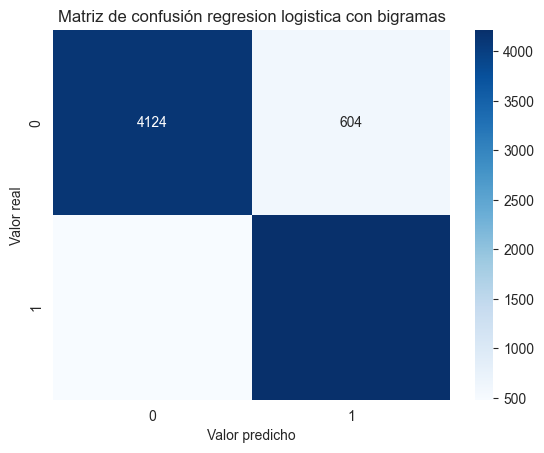

In [136]:
matriz_confusion = confusion_matrix(y_test, prediccion)
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues').set_title('Matriz de confusión regresion logistica con bigramas')
plt.xlabel('Valor predicho')
plt.ylabel('Valor real')
plt.show()

Se puede observar en este heatmap que nuestro modelo tiene tendencia a predecir a las reviews como positivas. 

In [137]:
prediccion_train = modelo_regresion_logistica.predict(x_train)

mostrar_scores(y_train, prediccion_train)

Accuracy: 0.8964876910016978
Recall: 0.9105828789242416
Precision: 0.8860042239736259
f1 score: 0.8981254242598298


In [ ]:
pickle.dump(modelo_regresion_logistica, open('modelos/regresion_logistica.pkl', 'wb'))

Lo raro a destacar de este modelo es que localmente nos brindo mejores resultados que el Bernoulli Bayes Naive, pero en kaggle obtuvimos peores resultados. 

#### Busqueda de hiperparametros

In [138]:
vectorizer = TfidfVectorizer(max_features=7000, ngram_range=(1, 2), min_df=5, max_df=0.7, binary=True)
X = vectorizer.fit_transform(df_preprocesado['review_es'])
y = df_preprocesado['sentimiento'].map({'negativo': 0, 'positivo': 1, 0: 0, 1: 1})

modelo_regresion_logistica = LogisticRegression()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l2']
space['C'] = [0.01, 0.1, 0.3, 0.5, 1.0, 3]
space['l1_ratio'] = [None]
space['max_iter'] = [50, 100, 200, 300]

n_iter = 1
search = RandomizedSearchCV(modelo_regresion_logistica, space, n_iter=5, scoring='f1', n_jobs=-1, cv=cv, random_state=42)
result = search.fit(X, y)

Con esto vemos los resultados de nuestra busqueda de hiperparametros.

In [139]:
print('Mejor Score: %s' % result.best_score_)
print('Mejores hiperparametros: %s' % result.best_params_)

promedios = result.cv_results_['mean_test_score']
params = result.cv_results_['params']
for promedio, param in zip(promedios, params):
    print(">%.3f with: %r" % (promedio, param))

Mejor Score: 0.8821962343105862
Mejores hiperparametros: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 50, 'l1_ratio': None, 'C': 3}
>0.858 with: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 100, 'l1_ratio': None, 'C': 0.01}
>0.882 with: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 50, 'l1_ratio': None, 'C': 3}
>0.873 with: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 200, 'l1_ratio': None, 'C': 0.1}
>0.858 with: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 50, 'l1_ratio': None, 'C': 0.01}
>0.879 with: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 100, 'l1_ratio': None, 'C': 0.3}


#### Predicción en los datos de test para kaggle

In [ ]:
df_test = pd.read_csv('datasets/test.csv', sep=',')
df_test_copia = df_test.copy()

df_test_copia['review_es'] = df_test_copia['review_es'].apply(demojize)
df_test_copia['review_es'] = df_test_copia['review_es'].apply(tokenize)

prediccion = modelo_regresion_logistica.predict(df_test_copia['review_es'])
prediccion = np.where(prediccion == 0, 'negativo', 'positivo')

df_entrega = df_test.copy()

df_entrega['sentimiento'] = prediccion
df_entrega.drop('review_es', axis=1, inplace=True)

df_entrega.to_csv('lr_preproceso_upgrade.csv', index=False)

### XGBoost

Seguiremos con un modelo de XGBoost ya que es un modelo que esperamos que va a tener muy buenos resultados.

In [140]:
vectorizer = TfidfVectorizer(max_features=7000, ngram_range=(1, 2), min_df=5, max_df=0.7, binary=True)
modelo_xg_boost = Pipeline([
  ('tfidf', vectorizer), 
  ('xgb', XGBClassifier(
        objective='binary:logistic',
        n_jobs=-1,
        random_state=42,
        colsample_bytree=0.6, 
        subsample=0.6,
        gamma=0.3, 
        max_depth=5,
        learning_rate=0.089, 
        min_child_weight=10, 
        n_estimators=700, 
))])

modelo_xg_boost.fit(x_train, y_train)

y_pred = modelo_xg_boost.predict(x_test)

mostrar_scores(y_test, y_pred)

Accuracy: 0.865025466893039
Recall: 0.8756388415672913
Precision: 0.8566666666666667
f1 score: 0.8660488626790228


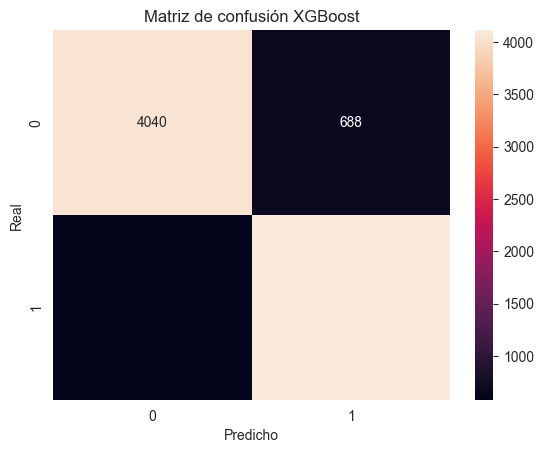

In [141]:
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, annot=True, fmt='d').set_title('Matriz de confusión XGBoost')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

A continuacion, vamos a analizar que tan overfitteado esta nuestro modelo ya que en el tp1 notamos que este modelo tiende a overfittearse facilmente. 

In [142]:
y_pred_train = modelo_xg_boost.predict(x_train)

mostrar_scores(y_train, y_pred_train)

Accuracy: 0.9188508064516129
Recall: 0.9304357033193923
Precision: 0.9096790890269151
f1 score: 0.9199403281949278


In [ ]:
pickle.dump(modelo_xg_boost, open('modelos/modelo_xg_boost.pkl', 'wb'))

Ademas de ser un poco mas costoso para entrenar comparado a los mdoelos anteriores, brinda peores resultados y se puede ver que esta levemente overfitteado. Para agregar, si bien localmente parece dar buenos numeros, en kaggle obtuvimos resultados muy pobres.

#### Busqueda de hiperparametros

In [143]:
vectorizer = TfidfVectorizer(max_features=7000, ngram_range=(1, 2), min_df=5, max_df=0.7, binary=True)
X = vectorizer.fit_transform(df_preprocesado['review_es'])
y = df_preprocesado['sentimiento'].map({'negativo': 0, 'positivo': 1, 0: 0, 1: 1})

modelo_xg_boost = XGBClassifier(
    objective='binary:logistic',
    n_jobs=-1,
    random_state=42
)

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.1,  0.3,  0.5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'learning_rate': list(np.linspace(0.001, 0.1, 10)),
        'n_estimators': [ 300, 400, 500, 600, 700, 800, 900, 1000],
        }

folds = 5
n_iter = 1
cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(modelo_xg_boost, param_distributions=params, n_iter=n_iter, scoring='f1', n_jobs=-1, cv=cv, random_state=42 )
random_search.fit(X, y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importan...
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.1, 0.3, 0.5],
                                        'learning_rate': [0.001, 0.012,
                                                          0.023000000000000003,
                                                          0.034,
                                                          0.045000000000000005,
                                                          0.05600000000000001,
                                                          0.067,
                                                          0.07800000000000001,
                                                          0.08900000000000001,
                                                          0.1],
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': [300, 400, 500, 600,
                                                         700, 800, 900, 1000],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='f1')

In [144]:
print('\n Mejor estimador:')
print(random_search.best_estimator_)
print('\n Mejor hiperparm:')
print(random_search.best_score_)


 Mejor estimador:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.012, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=900, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

 Mejor hiperparm:
0.8318231476152935


#### Predicción en los datos de test para kaggle

In [ ]:
df_test = pd.read_csv('datasets/test.csv', sep=',')
df_test_copia = df_test.copy()

df_test_copia['review_es'] = df_test_copia['review_es'].apply(demojize)
df_test_copia['review_es'] = df_test_copia['review_es'].apply(tokenize)


prediccion = modelo_xg_boost.predict(df_test_copia['review_es'])
prediccion = np.where(prediccion == 0, 'negativo', 'positivo')

df_entrega = df_test.copy()

df_entrega['sentimiento'] = prediccion
df_entrega.drop('review_es', axis=1, inplace=True)

df_entrega.to_csv('xgb.csv', index=False)

### Random Forest

Otro modelo que utilizaremos es el de Random Forest ya que es un modelo que esperamos que va a tener buenos resultados. Sin embargo, creemos que no va a superar a XGBoost. La ventaja de este modelo es que es muy rapido de entrenar y de predecir.

In [145]:
vectorizer = TfidfVectorizer(max_features=7000, ngram_range=(1, 2), min_df=5, max_df=0.7, binary=True)
modelo_random_forest = Pipeline([
    ('tfidf', vectorizer), 
    ('rfc', RandomForestClassifier(
            criterion='entropy',
            n_jobs=-1,
            random_state=42,
            max_depth=20,
            min_samples_leaf=50,
            n_estimators=900,
    ))])

modelo_random_forest.fit(x_train, y_train)

y_pred = modelo_random_forest.predict(x_test)

mostrar_scores(y_test, y_pred)

Accuracy: 0.8231112054329371
Recall: 0.8600936967632027
Precision: 0.7999603881956823
f1 score: 0.8289379168804515


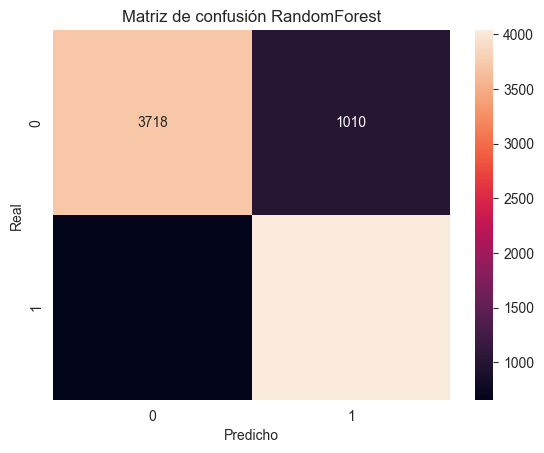

In [146]:
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, annot=True, fmt='d').set_title('Matriz de confusión RandomForest')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

In [147]:
y_pred_train = modelo_random_forest.predict(x_train)

mostrar_scores(y_train, y_pred_train)

Accuracy: 0.8417869269949066
Recall: 0.883741860341998
Precision: 0.8158447778700944
f1 score: 0.8484371029224905


In [ ]:
pickle.dump(modelo_random_forest, open('modelos/random_forest.pkl', 'wb'))

Este modelo fue una gran sorpresa porque dio resultados realmente bajos, tanto localmente como en kaggle. Quizas el inconveniente esta los parametros utilizados. Aunque hayamos puedos gran enfasis en la busqueda de hiperparametros, no pudimos encontrar una combinacion que nos brinde buenos resultados.

#### Busqueda de hiperparametros

In [148]:
vectorizer = TfidfVectorizer(max_features=7000, ngram_range=(1, 2), min_df=5, max_df=0.7, binary=True)
X = vectorizer.fit_transform(df_preprocesado['review_es'])
y = df_preprocesado['sentimiento'].map({'negativo': 0, 'positivo': 1, 0: 0, 1: 1})

modelo_random_forest = RandomForestClassifier(
    criterion='entropy',
    n_jobs=-1,
    random_state=42
)

params = {
        'n_estimators': [500, 750, 1000, 1250, 1500, 1750, 2000],
        'max_depth': [10, 20, 30, 40, 50, 60],
        'min_samples_leaf': [25, 50, 75, 100, 125, 150, 175, 200],
        'max_features': ['auto', 'sqrt', 'log2'],
        'class_weight': ['balanced', 'balanced_subsample']
        }
    
folds = 5
n_iter = 1
cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(modelo_random_forest, param_distributions=params, n_iter=n_iter, scoring='f1', n_jobs=-1, cv=cv, random_state=42 )
random_search.fit(X, y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(criterion='entropy',
                                                    n_jobs=-1,
                                                    random_state=42),
                   n_iter=1, n_jobs=-1,
                   param_distributions={'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'max_depth': [10, 20, 30, 40, 50, 60],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [25, 50, 75, 100,
                                                             125, 150, 175,
                                                             200],
                                        'n_estimators': [500, 750, 1000, 1250,
                                                         1500, 1750, 2000]},
                   random_state=42, scoring='f1')

In [149]:
print('\n Mejor estimador:')
print(random_search.best_estimator_)
print('\n Mejor hiperparm:')
print(random_search.best_score_ )


 Mejor estimador:
RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=10, max_features='log2', min_samples_leaf=25,
                       n_estimators=2000, n_jobs=-1, random_state=42)

 Mejor hiperparm:
0.8497119169302575


#### Predicción en los datos de test para kaggle

In [ ]:
df_test = pd.read_csv('datasets/test.csv', sep=',')
df_test_copia = df_test.copy()

df_test_copia['review_es'] = df_test_copia['review_es'].apply(demojize)
df_test_copia['review_es'] = df_test_copia['review_es'].apply(tokenize)

prediccion = modelo_random_forest.predict(df_test_copia['review_es'])
prediccion = np.where(prediccion == 0, 'negativo', 'positivo')

df_entrega = df_test.copy()

df_entrega['sentimiento'] = prediccion
df_entrega.drop('review_es', axis=1, inplace=True)

df_entrega.to_csv('random_forest.csv', index=False)

### SVM

Tambien decidimos implementar este modelo porque, averiguando en internet, vimos que es un modelo que tiene muy buenos resultados para este tipo de problemas. El problema de este modelo es que solo se entrena en un solo hilo, por lo tanto, es muy lento a la hora de entrenar y para predecir. Es por ello que exportamos el modelo entrenado para poder utilizarlo cuando se desee.

In [ ]:
vectorizer = TfidfVectorizer(max_features=7000, ngram_range=(1, 2))
modelo_svm = Pipeline([
    ('tfidf', vectorizer), 
    ('svm', SVC(C=1, probability=True, gamma=0.1, kernel='rbf'))
    ])

modelo_svm.fit(x_train, y_train)

y_pred = modelo_svm.predict(x_test)

mostrar_scores(y_test, y_pred)

In [ ]:
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, annot=True, fmt='d').set_title('Matriz de confusión SVM')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

In [ ]:
y_pred_train = modelo_svm.predict(x_train)

mostrar_scores(y_train, y_pred_train)    

In [ ]:
pickle.dump(modelo_svm, open('modelos/svm.pkl', 'wb'))

Por lo mencionado al principio, decidimos no realizar una busqueda de hiperparametros ya que el tiempo de entrenamiento seria muy largo.

#### Predicción en los datos de test para kaggle

In [ ]:
df_test = pd.read_csv('test.csv', sep=',')
df_test_copia = df_test.copy()

df_test_copia['review_es'] = df_test_copia['review_es'].apply(demojize)
df_test_copia['review_es'] = df_test_copia['review_es'].apply(tokenize)

prediccion = modelo_svm.predict(df_test_copia['review_es'])
prediccion = np.where(prediccion == 0, 'negativo', 'positivo')

df_entrega = df_test.copy()

df_entrega['sentimiento'] = prediccion
df_entrega.drop('review_es', axis=1, inplace=True)

df_entrega.to_csv('lr_preproceso_demoji.csv', index=False)

### Arbol de decision

In [150]:
vectorizer = TfidfVectorizer(max_features=7000, ngram_range=(1, 2), min_df=5, max_df=0.7, binary=True)
modelo_arbol = Pipeline([
    ('tfidf', vectorizer), 
    ('dtc', DecisionTreeClassifier(
            criterion='entropy',
            random_state=42,
            max_depth=120,
            min_samples_leaf=50,
            ccp_alpha=0.001,
    ))])

modelo_arbol.fit(x_train, y_train)

y_pred = modelo_arbol.predict(x_test)

mostrar_scores(y_test, y_pred)

Accuracy: 0.754881154499151
Recall: 0.7570272572402045
Precision: 0.7525402201524132
f1 score: 0.7547770700636943


Con estos resultados podemos determianr que es un modelo muy pobre comparado con los que venimos utilizando. Sin embargo, es un modelo muy rapido de entrenar y de predecir. Decidimos utilizarlo ya que en el tp1 nos brindo grandes resultados, pero seguramente no es un modelo muy positivo para este tipo de problemas.

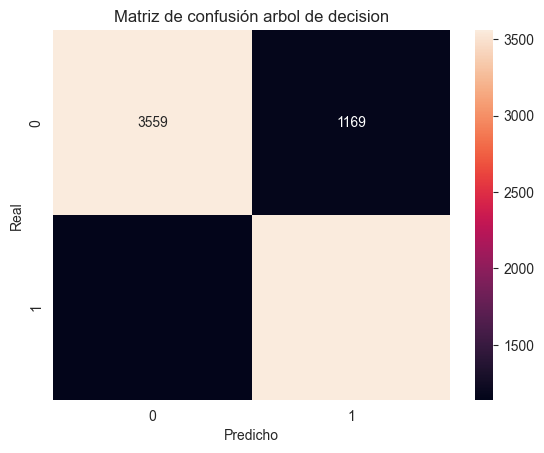

In [151]:
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, annot=True, fmt='d').set_title('Matriz de confusión arbol de decision')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

In [152]:
y_pred_train = modelo_arbol.predict(x_train)

mostrar_scores(y_train, y_pred_train)

Accuracy: 0.7589664685908319
Recall: 0.7648896182963629
Precision: 0.756717121458126
f1 score: 0.7607814227792111


In [ ]:
pickle.dump(modelo_svm, open('modelos/arbol_decision.pkl', 'wb'))

### Red Neuronal

Vamos a intentar en primer lugar con una red neuronal simple con GRU para ver que resultados nos brinda. Luego, vamos a probar con una red neuronalmas compleja para ver si podemos mejorar los resultados.

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)
keras.utils.set_random_seed(812)
os.environ['PYTHONHASHSEED']=str(1)


df_preprocesado_copy = df_preprocesado.copy()
df_preprocesado_copy['sentimiento'] = df_preprocesado_copy['sentimiento'].map({'negativo': 0, 'positivo': 1})

max_words = 10000
max_len = 1000
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(x_train)
sequences = tok.texts_to_sequences(x_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

def red_neuronal_recurrente():
    inputs = Input(name='inputs', shape=[max_len])
    layer = Embedding(max_words, 128, input_length=max_len)(inputs)
    layer = GRU(64)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = tf.keras.Model(inputs=inputs,outputs=layer)
    return model

model_rnn = red_neuronal_recurrente()
model_rnn.summary()
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_rnn.fit(sequences_matrix, y_train, batch_size=128, epochs=10, 
            validation_split=0.3,callbacks=[EarlyStopping(min_delta=0.0001)])

test_sequences = tok.texts_to_sequences(x_test)
test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)

accr = model_rnn.evaluate(test_sequences_matrix, y_test)

print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

prediccion = model_rnn.predict(test_sequences_matrix)
prediccion = np.where(prediccion >= 0.5, 1, 0)
mostrar_scores(y_test, prediccion)
prediccion = np.where(prediccion == 1, 'positivo', 'negativo')


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1000)]            0         
                                                                 
 embedding_6 (Embedding)     (None, 1000, 128)         1280000   
                                                                 
 gru_3 (GRU)                 (None, 64)                37248     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 out_layer (Dense)           (None, 1)                 257       
                                                                 
 activation_3 (Activation)   (None, 1)                 0         
                                                                 
Total params: 1334145 (5.09 MB)
Trainable params: 1334145 (

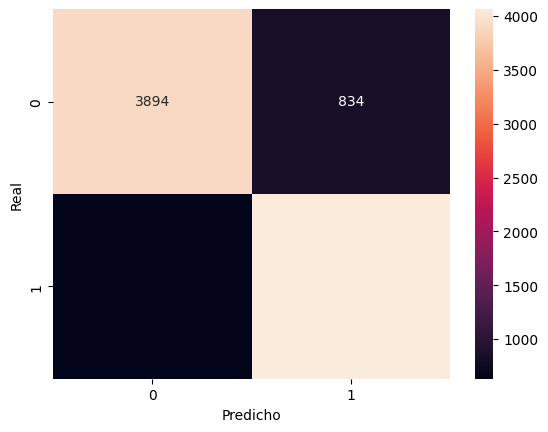

In [ ]:
prediccion_heatmap = np.where(prediccion == 'positivo', 1, 0)

tabla = confusion_matrix(y_test, prediccion_heatmap)
sns.heatmap(tabla, annot=True, fmt='d')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

In [54]:
train_sequences = tok.texts_to_sequences(x_train)
train_sequences_matrix = pad_sequences(train_sequences, maxlen=max_len)
prediccion_train = model_rnn.predict(train_sequences_matrix)
prediccion_train = np.where(prediccion_train >= 0.5, 1, 0)
mostrar_scores(y_train, prediccion_train)

1178/1178 [==============================] - 29s 25ms/step
Accuracy: 0.949411078098472
Recall: 0.9572237810365821
Precision: 0.9427007299270073
f1 score: 0.9499067482728729


Como podemos ver, los resultados no son malos pero vamos a intentar con una capa convolucional para ver si podemos mejorar los resultados.

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)
keras.utils.set_random_seed(812)
os.environ['PYTHONHASHSEED']=str(1)

df_preprocesado_copy = df_preprocesado.copy()
df_preprocesado_copy['sentimiento'] = df_preprocesado_copy['sentimiento'].map({'negativo': 0, 'positivo': 1})
x_train, x_test, y_train, y_test = train_test_split(df_preprocesado_copy['review_es'], df_preprocesado_copy['sentimiento'], test_size=0.3, random_state=42)

max_len = 1000
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(x_train)
sequences = tok.texts_to_sequences(x_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=128),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x=sequences_matrix, y=y_train, epochs=10)


Epoch 1/10


2023-11-15 22:15:33.883538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-15 22:15:33.884783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-15 22:15:33.885307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1085/1085 [==============================] - 553s 509ms/step - loss: 0.4476 - accuracy: 0.7848
Epoch 2/10
1085/1085 [==============================] - 536s 494ms/step - loss: 0.2515 - accuracy: 0.8988
Epoch 3/10
1085/1085 [==============================] - 531s 489ms/step - loss: 0.1804 - accuracy: 0.9318
Epoch 4/10
1085/1085 [==============================] - 533s 491ms/step - loss: 0.1094 - accuracy: 0.9612
Epoch 5/10
1085/1085 [==============================] - 539s 497ms/step - loss: 0.0599 - accuracy: 0.9803
Epoch 6/10
1085/1085 [==============================] - 553s 509ms/step - loss: 0.0414 - accuracy: 0.9860
Epoch 7/10
1085/1085 [==============================] - 540s 498ms/step - loss: 0.0246 - accuracy: 0.9921
Epoch 8/10
1085/1085 [==============================] - 539s 497ms/step - loss: 0.0200 - accuracy: 0.9933
Epoch 9/10
1085/1085 [==============================] - 536s 494ms/step - loss: 0.0201 - accuracy: 0.9929
Epoch 10/10
1085/1085 [==============================] - 

In [ ]:
test_sequences = tok.texts_to_sequences(x_test)
test_sequences_matrix = pad_sequences(test_sequences, maxlen=1000)
prediccion = model.predict(test_sequences_matrix)
prediccion = np.where(prediccion >= 0.5, 1, 0)
mostrar_scores(y_test, prediccion)
prediccion = np.where(prediccion == 1, 'positivo', 'negativo')

465/465 [==============================] - 53s 113ms/step
Accuracy: 0.8436155913978495
Recall: 0.8690796555435952
Precision: 0.8266990912581594
f1 score: 0.8473597900951131


In [ ]:
train_sequences = tok.texts_to_sequences(x_train)
train_sequences_matrix = pad_sequences(train_sequences, maxlen=max_len)
prediccion_train = model.predict(train_sequences_matrix)
prediccion_train = np.where(prediccion_train >= 0.5, 1, 0)
mostrar_scores(y_train, prediccion_train)

2023-11-15 23:53:15.747490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-15 23:53:15.748132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-15 23:53:15.748825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1085/1085 [==============================] - 126s 115ms/step
Accuracy: 0.9976669834960684
Recall: 0.999427065429128
Precision: 0.9959463317156723
f1 score: 0.997683662672653


#### Red neuronal Pooled GRU

In [58]:
#np.random.seed(1)
#tf.random.set_seed(1)

#keras.utils.set_random_seed(812)
#os.environ['PYTHONHASHSEED']=str(1)
#df_preprocesado_copy = df_preprocesado.copy()
#df_preprocesado_copy['sentimiento'] = df_preprocesado_copy['sentimiento'].map({'negativo': 0, 'positivo': 1})

# max_words = 512
# max_len = 1000
# tok = Tokenizer(num_words=max_words)
# tok.fit_on_texts(x_train)
# sequences = tok.texts_to_sequences(x_train)
# sequences_matrix = pad_sequences(sequences,maxlen=max_len)

# input_layer = Input(shape=(max_len,))
# embedding_layer = Embedding(max_words, 64, input_length=max_len)(input_layer)

# gru_layer = Bidirectional(GRU(250, return_sequences=True))(embedding_layer)

# avg_pool = GlobalAveragePooling1D()(gru_layer)
# max_pool = GlobalMaxPooling1D()(gru_layer)

# concatenated = Concatenate()([avg_pool, max_pool])

# dense_layer = Dense(512, activation='relu')(concatenated)
# dropout_layer = Dropout(0.5)(dense_layer)
# output_layer = Dense(2, activation='softmax')(dropout_layer)


# model = Model(inputs=input_layer, outputs=output_layer)

# model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.1), metrics=['accuracy'])
# model.fit(x=sequences_matrix, y=y_train, epochs=25)



KeyboardInterrupt: 

Observando los resultados, podemos ver que no son muy buenos. Es posible que haya que realizar mayor regularizacion para evitar el overfitting, sin embargo el modelo es muy costoso de entrenar por lo tanto lo vamos a dejar aca.

### Ensamble de modelos

Como ultimo paso, vamos a realizar un ensamble de los modelos que mejor resultados nos dieron. Para este caso nos vino bien los modelos extras que realizamos.

#### Voting Classifier

In [163]:

estimators = [ ('lr', modelo_regresion_logistica), 
            ('mnb', modelo_bigramas), ('mnb2', modelo_bernoulli), ('xgb', modelo_xg_boost), ('rf', modelo_random_forest)]
ensamble_voting = VotingClassifier(estimators=estimators, voting='hard')
ensamble_voting.fit(x_train, y_train)
    
prediccion = ensamble_voting.predict(x_test)
mostrar_scores(y_test, prediccion)

Accuracy: 0.8790322580645161
Recall: 0.9022572402044293
Precision: 0.8615290768605124
f1 score: 0.8814229249011858


Exportamos el modelo

In [ ]:
pickle.dump(ensamble_voting, open('modelos/ensamble_voting.pkl', 'wb'))

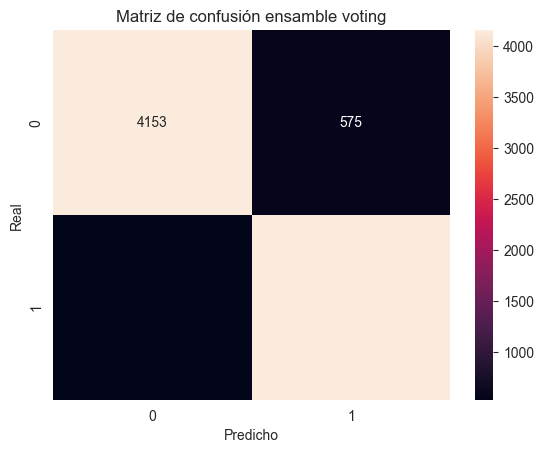

In [175]:
tabla = confusion_matrix(y_test, prediccion)
sns.heatmap(tabla, annot=True, fmt='d').set_title('Matriz de confusión ensamble voting')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

In [165]:
prediccion_train = ensamble_voting.predict(x_train)

mostrar_scores(y_train, prediccion_train)

Accuracy: 0.9010770373514432
Recall: 0.9231298639419768
Precision: 0.8844983260626965
f1 score: 0.9034012900551771


#### Stacking Classifier

Para este caso vamos a probar dos variantes, uno con regresion logistica de metamodelo y otro con un random forest. 

##### Regresion logistica como metamodelo

In [167]:

estimators = [('xgb', modelo_xg_boost), ('lr', modelo_regresion_logistica), 
            ('mnb', modelo_bernoulli), ('rfc', modelo_random_forest), ('mnb2', modelo_bernoulli)]

metamodel = LogisticRegression(random_state=33, max_iter=1000, solver="liblinear", penalty='l2', C=0.3)

ensamble_stacking_lr = StackingClassifier(estimators=estimators, final_estimator=metamodel, cv=5)
ensamble_stacking_lr.fit(x_train, y_train)

prediccion = ensamble_stacking_lr.predict(x_test)
mostrar_scores(y_test, prediccion)

Accuracy: 0.8880517826825127
Recall: 0.895655877342419
Precision: 0.8815761894780968
f1 score: 0.8885602619626068


Exportamos el modelo

In [168]:
pickle.dump(ensamble_stacking_lr, open('modelos/ensamble_stacking_lr.pkl', 'wb'))

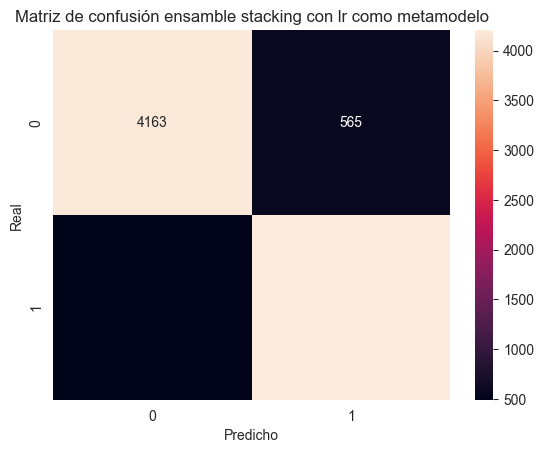

In [169]:
tabla = confusion_matrix(y_test, prediccion)
sns.heatmap(tabla, annot=True, fmt='d').set_title('Matriz de confusión ensamble stacking con lr como metamodelo')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

In [170]:
prediccion_train = ensamble_stacking_lr.predict(x_train)

mostrar_scores(y_train, prediccion_train)

Accuracy: 0.9104679541595926
Recall: 0.9194769442532691
Precision: 0.9035480178961607
f1 score: 0.911442890504054


##### Random forest como metamodelo

In [171]:

estimators = [('xgb', modelo_xg_boost), ('lr', modelo_regresion_logistica), 
            ('mnb', modelo_bernoulli), ('rfc', modelo_random_forest), ('mnb2', modelo_bernoulli)]

metamodel = RandomForestClassifier(
    criterion='entropy',
    n_jobs=-1,
    random_state=42,
    n_estimators=1000,
)

ensamble_stacking_rf = StackingClassifier(estimators=estimators, final_estimator=metamodel, cv=5)
ensamble_stacking_rf.fit(x_train, y_train)

prediccion = ensamble_stacking_rf.predict(x_test)
mostrar_scores(y_test, prediccion)

Accuracy: 0.8821095076400679
Recall: 0.8858603066439523
Precision: 0.8785638859556494
f1 score: 0.8821970098610964


Exportamos el modelo

In [32]:
pickle.dump(ensamble_stacking_rf, open('modelos/ensamble_stacking_rf.pkl', 'wb'))

In [3]:
tabla = confusion_matrix(y_test, prediccion)
sns.heatmap(tabla, annot=True, fmt='d').set_title('Matriz de confusión ensamble stacking con rf como metamodelo')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

NameError: name 'y_test' is not defined

In [173]:
prediccion_train = ensamble_stacking_rf.predict(x_train)

mostrar_scores(y_train, prediccion_train)

Accuracy: 0.9124575551782682
Recall: 0.9164593149452062
Precision: 0.9095255608679662
f1 score: 0.9129792732450821


##### Arbol de decision como metamodelo

In [179]:

estimators = [('xgb', modelo_xg_boost), ('lr', modelo_regresion_logistica), 
            ('mnb', modelo_bernoulli), ('rfc', modelo_random_forest), ('mnb2', modelo_bernoulli)]

arbol = DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth=120,
)

ensamble_stacking_arbol = StackingClassifier(estimators=estimators, final_estimator=metamodel, cv=5)
ensamble_stacking_arbol.fit(x_train, y_train)

prediccion = ensamble_stacking_arbol.predict(x_test)
mostrar_scores(y_test, prediccion)

Accuracy: 0.8880517826825127
Recall: 0.895655877342419
Precision: 0.8815761894780968
f1 score: 0.8885602619626068


In [40]:
pickle.dump(ensamble_stacking_arbol, open('modelos/ensamble_stacking_arbol.pkl', 'wb'))

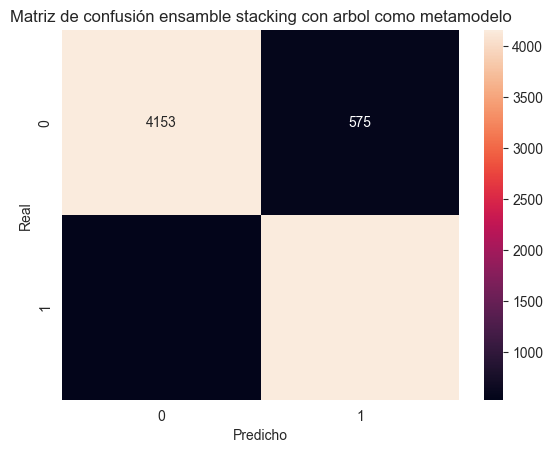

In [177]:
tabla = confusion_matrix(y_test, prediccion)
sns.heatmap(tabla, annot=True, fmt='d').set_title('Matriz de confusión ensamble stacking con arbol como metamodelo')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

In [178]:
prediccion_train = ensamble_stacking_arbol.predict(x_train)

mostrar_scores(y_train, prediccion_train)

NameError: name 'ensamble_stacking_arbol' is not defined

A modo resumen de esta seccion de ensambles stacking, podemos ver que los 3 modelos se comoportaron de manera similar. Sin embargo, el que mejor resultados nos brindo fue el que tiene como metamodelo a la regresion logistica.

#### Prediccion en los datos de test

In [53]:
df_test = pd.read_csv('datasets/test.csv', sep=',')
df_test_copia = df_test.copy()

df_test_copia['review_es'] = df_test_copia['review_es'].apply(demojize)
df_test_copia['review_es'] = df_test_copia['review_es'].apply(tokenize)

prediccion = ensamble_stacking_lr.predict(df_test_copia['review_es'])
prediccion = np.where(prediccion == 0, 'negativo', 'positivo')

df_entrega = df_test.copy()

df_entrega['sentimiento'] = prediccion
df_entrega.drop('review_es', axis=1, inplace=True)

df_entrega.to_csv('stacking_lr.csv', index=False)